In [1]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use('dark_background')

In [2]:
df_train = pd.read_csv('sf_crimes.csv').sample(frac=0.5, replace=False, random_state=42)

In [3]:
df_train.shape

(437863, 31)

In [4]:
value_counts = df_train.category_ord_enc.value_counts()
category_cnts = [ (id, cnt) for (id, cnt) in zip(value_counts.index, value_counts.values) ]
category_cnts

[(16, 87172),
 (21, 62899),
 (20, 45930),
 (1, 38330),
 (7, 26902),
 (36, 26772),
 (35, 22532),
 (37, 21230),
 (4, 18280),
 (32, 15625),
 (19, 12873),
 (25, 11384),
 (13, 8384),
 (12, 5332),
 (27, 4986),
 (38, 4252),
 (23, 3759),
 (34, 3637),
 (30, 2352),
 (28, 2197),
 (5, 2127),
 (8, 2125),
 (24, 1587),
 (15, 1124),
 (6, 1123),
 (17, 954),
 (26, 942),
 (0, 760),
 (18, 601),
 (9, 586),
 (11, 249),
 (31, 247),
 (2, 196),
 (3, 145),
 (10, 115),
 (14, 74),
 (29, 67),
 (22, 10),
 (33, 3)]

In [5]:
df_train.drop(df_train[df_train.category_ord_enc.isin([ x[0] for x in category_cnts[-5:] ])].index, inplace=True)

In [6]:
df_train.shape

(437594, 31)

In [7]:
for i in range(5):
    category_cnts.pop()

In [8]:
category_bins = dict()
category_bins_avgs = dict()

category_bins[0] = category_cnts[:3]
category_bins[1] = category_cnts[3:9]
category_bins[2] = category_cnts[9:18]
category_bins[3] = category_cnts[18:24]
category_bins[4] = category_cnts[24:]

print(category_bins)

for i, bin_items in enumerate(category_bins.values()):
    category_bins_avgs[i] =  int(np.ceil(sum( x[1] for x in bin_items ) / len(bin_items)))

category_bins_avgs

{0: [(16, 87172), (21, 62899), (20, 45930)], 1: [(1, 38330), (7, 26902), (36, 26772), (35, 22532), (37, 21230), (4, 18280)], 2: [(32, 15625), (19, 12873), (25, 11384), (13, 8384), (12, 5332), (27, 4986), (38, 4252), (23, 3759), (34, 3637)], 3: [(30, 2352), (28, 2197), (5, 2127), (8, 2125), (24, 1587), (15, 1124)], 4: [(6, 1123), (17, 954), (26, 942), (0, 760), (18, 601), (9, 586), (11, 249), (31, 247), (2, 196), (3, 145)]}


{0: 65334, 1: 25675, 2: 7804, 3: 1919, 4: 581}

In [9]:
from collections import Counter


def plot_class_cnts(title, xlabel, ylabel, data):
    
    _, ax = plt.subplots(1, 1, figsize=(7, 7))

    counter = Counter(data)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.bar(counter.keys(), counter.values())


In [10]:
X, y = df_train.drop(columns=['category_ord_enc', 'category'], axis=1).values, df_train['category_ord_enc']

f'{X.shape=}', f'{y.shape=}'

('X.shape=(437594, 29)', 'y.shape=(437594,)')

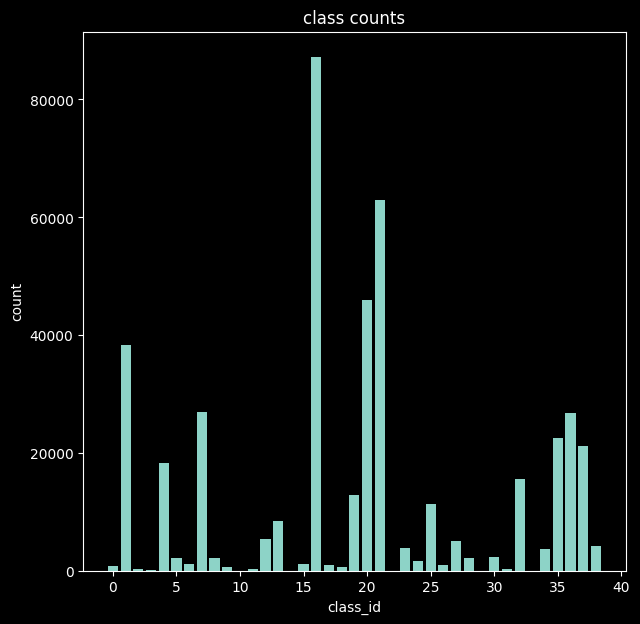

In [11]:
plot_class_cnts('class counts', 'class_id', 'count', y)

In [12]:
oversample_stategy = dict()

for i, bin_items in enumerate(category_bins.values()):
    for item in bin_items:
        category_id = item[0]
        category_cnt = item[1]
        
        if category_cnt < category_bins_avgs[i]:
            oversample_stategy[category_id] = int(category_bins_avgs[i])

oversample_stategy

{21: 65334,
 20: 65334,
 35: 25675,
 37: 25675,
 4: 25675,
 12: 7804,
 27: 7804,
 38: 7804,
 23: 7804,
 34: 7804,
 24: 1919,
 15: 1919,
 11: 581,
 31: 581,
 2: 581,
 3: 581}

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=12)

X_embed = pca.fit_transform(X)

f'{X_embed.shape=}, {np.sum(pca.explained_variance_ratio_[:])=}'

'X_embed.shape=(437594, 12), np.sum(pca.explained_variance_ratio_[:])=0.9553587465010144'

In [14]:
y_np = y.to_numpy()

In [15]:
under_group_avg_indeces = np.nonzero(np.isin(y_np, list(oversample_stategy.keys())))[0]

over_group_avg_indeces = np.nonzero(np.isin(y_np, list(set(df_train.category_ord_enc.unique()) - set(oversample_stategy.keys()))))[0]

f'{len(under_group_avg_indeces)=}, {len(over_group_avg_indeces)=}'

'len(under_group_avg_indeces)=196385, len(over_group_avg_indeces)=241209'

In [16]:
X_embed_under, y_under = X_embed[under_group_avg_indeces], y_np[under_group_avg_indeces]

f'{X_embed_under.shape=}', f'{y_under.shape=}'

('X_embed_under.shape=(196385, 12)', 'y_under.shape=(196385,)')

In [17]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy=oversample_stategy, k_neighbors=1)

X_embed_under, y_under = oversample.fit_resample(X_embed_under, y_under)

f'{X_embed_under.shape=}', f'{y_under.shape=}'

('X_embed_under.shape=(252875, 12)', 'y_under.shape=(252875,)')

In [18]:
majority_classes = list(set(df_train.category_ord_enc.unique()) - set(oversample_stategy.keys()))

In [19]:
X_embed_over, y_over = X_embed[over_group_avg_indeces], y_np[over_group_avg_indeces]

f'{X_embed_over.shape=}', f'{y_over.shape=}'

('X_embed_over.shape=(241209, 12)', 'y_over.shape=(241209,)')

In [20]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

undersample = NeighbourhoodCleaningRule(sampling_strategy='not minority', n_neighbors=1)
X_embed_over, y_over = undersample.fit_resample(X_embed_over, y_over)

f'{X_embed_over.shape=}', f'{y_over.shape=}'

('X_embed_over.shape=(90831, 12)', 'y_over.shape=(90831,)')

In [21]:
X = np.concatenate((X_embed_under, X_embed_over), axis=0)
y = np.concatenate((y_under, y_over), axis=0)

f'{X.shape=}, {y.shape=}'

'X.shape=(343706, 12), y.shape=(343706,)'

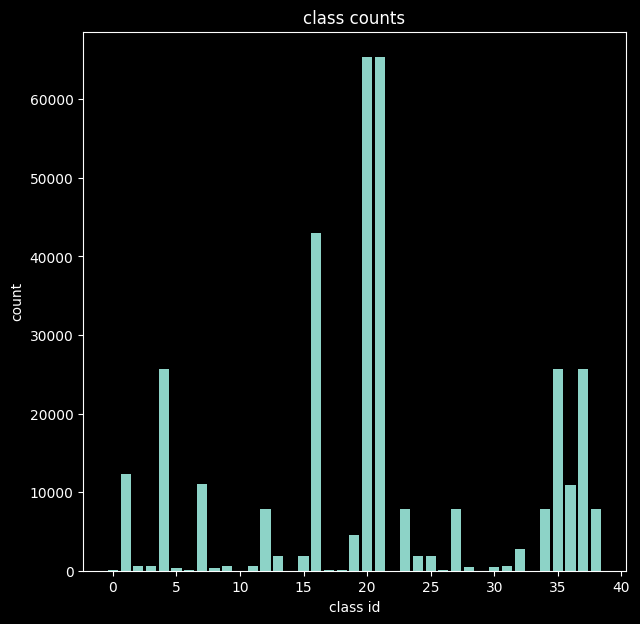

In [22]:
plot_class_cnts('class counts', 'class id', 'count', y)

In [23]:
oversample = SMOTE(k_neighbors=1)
X, y = oversample.fit_resample(X, y)

f'{X.shape=}', f'{y.shape=}'

('X.shape=(2221356, 12)', 'y.shape=(2221356,)')

In [1]:
from random import sample

sample_size = 10 ** 4
random_idxes = sample(range(X.shape[0]), sample_size)
sample_size

NameError: name 'X' is not defined

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(X[random_idxes])

/home/george/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/george/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.054s...
[t-SNE] Computed neighbors for 10000 samples in 2.427s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.261110
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.482117
[t-SNE] KL divergence after 1000 iterations: 1.848706


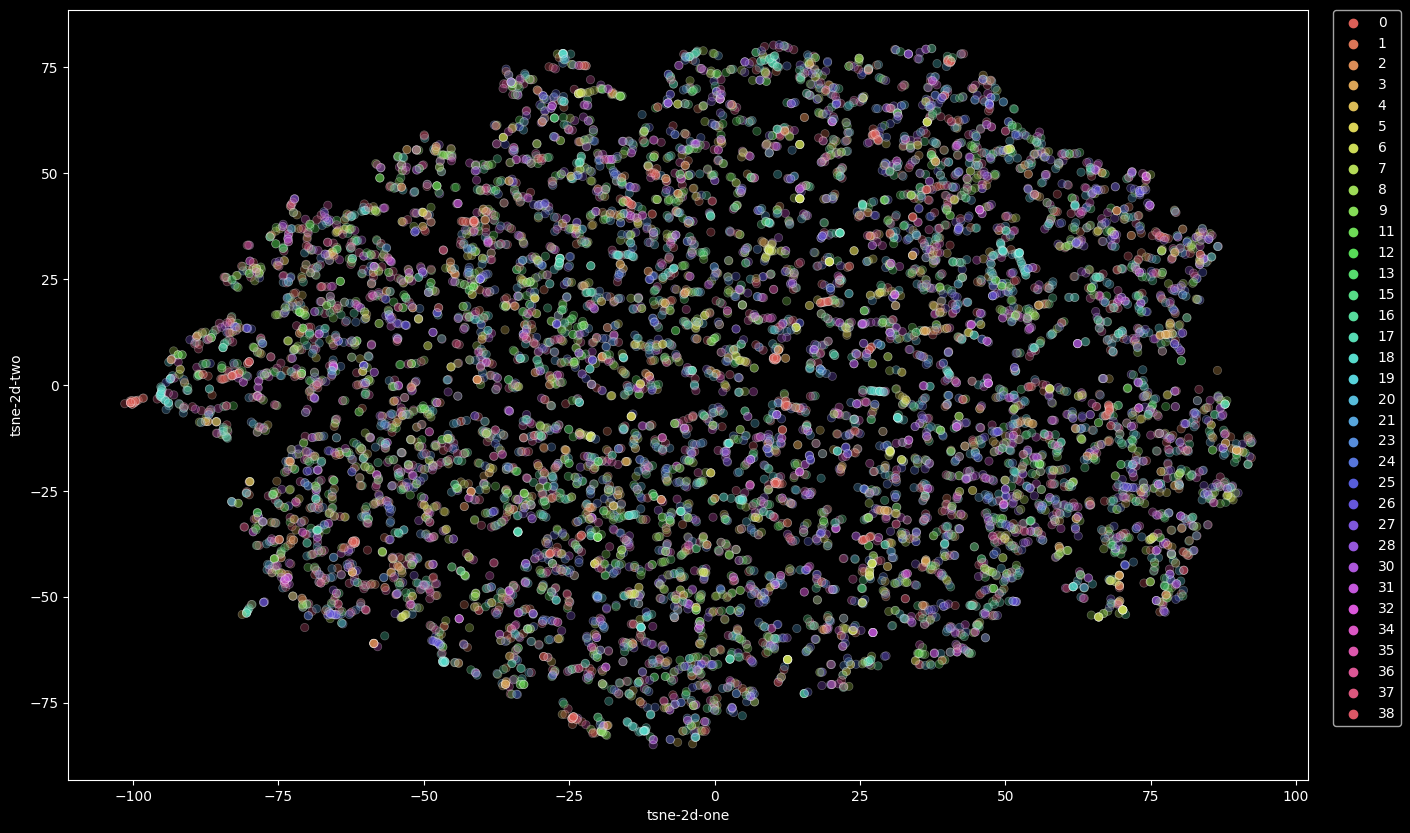

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))

sns.scatterplot(
    x='tsne-2d-one', 
    y='tsne-2d-two', 
    hue='category_id', 
    data={
        'tsne-2d-one': tsne_results[:, 0], 
        'tsne-2d-two': tsne_results[:, 1], 
        'category_id': y[random_idxes] 
    },
    palette=sns.color_palette('hls', 34),
    alpha=0.3,
    ax=ax
)

ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

In [38]:
sample_size = 6 * 10 ** 5
random_idxes = sample(range(X.shape[0]), sample_size)
print(sample_size)

600000


In [39]:
X = X[random_idxes]
y = y[random_idxes]

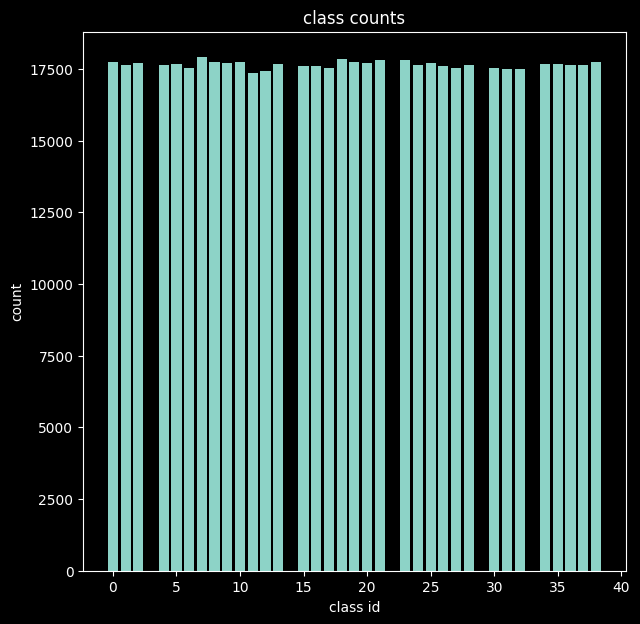

In [40]:
plot_class_cnts('class counts', 'class id', 'count', y)

In [41]:
from sklearn.model_selection import train_test_split

ix = list(range(len(X)))
dev_size, test_size = 0.2, 0.1

dev_slice = dev_size + test_size
test_slice = test_size / dev_size

ix_train, ix_dev = train_test_split(ix, test_size=dev_slice, random_state=42, stratify=y)
ix_dev, ix_test = train_test_split(ix_dev, test_size=test_slice, random_state=42, stratify=y[ix_dev])

In [42]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier()

hgs_cv = HalvingGridSearchCV(
    estimator=knn,
    param_grid={
        'n_neighbors': range(1, 25),
        'n_jobs':[-1],
        'algorithm': ['kd_tree'],
        'leaf_size': [90],
        'weights': ['distance'],
    },
    cv=3,
    scoring='f1_weighted',
    return_train_score=True,
    verbose=3
)

hgs_cv.fit(X[ix_train], y[ix_train])

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 46666
max_resources_: 419999
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 24
n_resources: 46666
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END algorithm=kd_tree, leaf_size=90, n_jobs=-1, n_neighbors=1, weights=distance;, score=(train=0.995, test=0.544) total time=   1.9s
[CV 2/3] END algorithm=kd_tree, leaf_size=90, n_jobs=-1, n_neighbors=1, weights=distance;, score=(train=0.995, test=0.546) total time=   0.5s
[CV 3/3] END algorithm=kd_tree, leaf_size=90, n_jobs=-1, n_neighbors=1, weights=distance;, score=(train=0.995, test=0.551) total time=   0.5s
[CV 1/3] END algorithm=kd_tree, leaf_size=90, n_jobs=-1, n_neighbors=2, weights=distance;, score=(train=0.996, test=0.545) total time=   0.6s
[CV 2/3] END algorithm=kd_tree, leaf_size=90, n_jobs=-1, n_neighbors=2, weights=distance;, score=(train=0.996, test=0.546) total time=   0.7s
[CV 3/3] END algorithm=

HalvingGridSearchCV(cv=3, estimator=KNeighborsClassifier(),
                    param_grid={'algorithm': ['kd_tree'], 'leaf_size': [90],
                                'n_jobs': [-1], 'n_neighbors': range(1, 25),
                                'weights': ['distance']},
                    scoring='f1_weighted', verbose=3)

In [43]:
hgs_cv_df = pd.DataFrame(hgs_cv.cv_results_)
hgs_cv_df.columns

Index(['iter', 'n_resources', 'mean_fit_time', 'std_fit_time',
       'mean_score_time', 'std_score_time', 'param_algorithm',
       'param_leaf_size', 'param_n_jobs', 'param_n_neighbors', 'param_weights',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [44]:
hgs_cv_df[['param_n_neighbors', 'mean_test_score', 'mean_train_score']].sort_values(by=['mean_test_score'], ascending=False).head()

,param_n_neighbors,mean_test_score,mean_train_score
34,2,0.823193,0.988250
33,1,0.822813,0.987935
32,3,0.813004,0.990333
31,2,0.697352,0.992864
30,1,0.696953,0.992498


In [31]:
hgs_cv.best_estimator_

KNeighborsClassifier(algorithm='kd_tree', leaf_size=90, n_jobs=-1,
                     n_neighbors=1, weights='distance')

In [45]:
y_pred = hgs_cv.best_estimator_.predict(X[ix_test])
y_pred_proba = hgs_cv.best_estimator_.predict_proba(X[ix_test])

In [46]:
from sklearn.metrics import classification_report, roc_auc_score, \
    cohen_kappa_score, matthews_corrcoef, log_loss


print(classification_report(y[ix_test], y_pred, target_names=df_train.category.unique()))

print(f'{roc_auc_score(y[ix_test], y_pred_proba, average="macro", multi_class="ovr")=}')
print(f'{cohen_kappa_score(y[ix_test], y_pred)=}')
print(f'{matthews_corrcoef(y[ix_test], y_pred)=}')
print(f'{log_loss(y[ix_test], y_pred_proba)=}')

                             precision    recall  f1-score   support

               NON-CRIMINAL       0.99      1.00      1.00      2660
                   WARRANTS       0.71      0.72      0.71      2643
              LARCENY/THEFT       0.99      1.00      0.99      2656
                      FRAUD       0.65      0.67      0.66      2647
             OTHER OFFENSES       0.96      1.00      0.98      2651
                   BURGLARY       0.99      1.00      0.99      2631
              VEHICLE THEFT       0.78      0.84      0.81      2685
                    ROBBERY       0.97      1.00      0.99      2660
             SUSPICIOUS OCC       0.98      0.99      0.99      2656
                    ASSAULT       0.99      1.00      1.00      2660
            SECONDARY CODES       0.99      1.00      1.00      2605
              DRUG/NARCOTIC       0.83      0.91      0.87      2616
     FORGERY/COUNTERFEITING       0.90      0.97      0.94      2648
                DRUNKENNESS      

In [47]:
class_ratio = [value / y[ix_test].shape[0] for value in list(Counter(y[ix_test]).values())]

In [48]:
rand_preds = np.random.choice(
    range(len(np.unique(y[ix_test]))),
    len(y[ix_test]),
    p=class_ratio
)

In [49]:
cohen_kappa_score(y[ix_test], rand_preds)

-0.000438118621751693

In [55]:
X.shape, y.shape

((400000, 12), (400000,))

In [57]:
y_onehot = pd.get_dummies(pd.Series(y)).values

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [92]:
import tensorflow as tf
from tensorflow import keras

seq_model = keras.Sequential(
    [
        keras.layers.Input(shape=(X_embed.shape[1],)),
        keras.layers.Dense(units=720, activation="relu"),
        keras.layers.Dense(units=510, activation="relu"),
        keras.layers.Dense(units=254, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=64, activation="relu"),
        keras.layers.Dense(units=len(np.unique(y)), activation="softmax")
    ], name='Seq1'
)

seq_model.summary()

Model: "Seq1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 720)               9360      
                                                                 
 dense_61 (Dense)            (None, 510)               367710    
                                                                 
 dense_62 (Dense)            (None, 254)               129794    
                                                                 
 dense_63 (Dense)            (None, 128)               32640     
                                                                 
 dense_64 (Dense)            (None, 64)                8256      
                                                                 
 dense_65 (Dense)            (None, 39)                2535      
                                                                 
Total params: 550,295
Trainable params: 550,295
Non-trainable 

In [93]:
from keras import backend as k_back

optimizer = keras.optimizers.Adam(learning_rate=0.01)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

seq_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

seq_model_hist = seq_model.fit(X[ix_train], y_onehot[ix_train], epochs=15, batch_size=2048, validation_data=(X[ix_dev], y_onehot[ix_dev]), callbacks=[callback])

seq_model_hist

Epoch 1/15
137/137 [==============================] - 10s 65ms/step - loss: 2.9332 - accuracy: 0.2204 - val_loss: 2.4809 - val_accuracy: 0.3444
Epoch 2/15
137/137 [==============================] - 9s 63ms/step - loss: 2.2007 - accuracy: 0.4089 - val_loss: 2.0313 - val_accuracy: 0.4512
Epoch 3/15
137/137 [==============================] - 9s 64ms/step - loss: 1.9129 - accuracy: 0.4784 - val_loss: 1.8385 - val_accuracy: 0.4976
Epoch 4/15
137/137 [==============================] - 9s 65ms/step - loss: 1.8036 - accuracy: 0.5063 - val_loss: 1.7955 - val_accuracy: 0.5097
Epoch 5/15
137/137 [==============================] - 9s 64ms/step - loss: 1.8233 - accuracy: 0.5059 - val_loss: 1.7476 - val_accuracy: 0.5204
Epoch 6/15
137/137 [==============================] - 9s 66ms/step - loss: 1.6397 - accuracy: 0.5428 - val_loss: 1.6437 - val_accuracy: 0.5443
Epoch 7/15
137/137 [==============================] - 9s 67ms/step - loss: 1.5728 - accuracy: 0.5584 - val_loss: 1.6059 - val_accuracy: 0.552

In [94]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

seq_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

seq_model_hist = seq_model.fit(X[ix_train], y_onehot[ix_train], epochs=20, initial_epoch=15, batch_size=2048, validation_data=(X[ix_dev], y_onehot[ix_dev]), callbacks=[callback])

seq_model_hist

Epoch 16/20
137/137 [==============================] - 10s 66ms/step - loss: 1.2566 - accuracy: 0.6280 - val_loss: 1.3148 - val_accuracy: 0.6190
Epoch 17/20
137/137 [==============================] - 9s 66ms/step - loss: 1.2010 - accuracy: 0.6413 - val_loss: 1.2968 - val_accuracy: 0.6259
Epoch 18/20
137/137 [==============================] - 9s 67ms/step - loss: 1.1755 - accuracy: 0.6479 - val_loss: 1.2839 - val_accuracy: 0.6311
Epoch 19/20
137/137 [==============================] - 9s 67ms/step - loss: 1.1569 - accuracy: 0.6533 - val_loss: 1.2755 - val_accuracy: 0.6346
Epoch 20/20
137/137 [==============================] - 9s 66ms/step - loss: 1.1404 - accuracy: 0.6584 - val_loss: 1.2705 - val_accuracy: 0.6389


In [95]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

seq_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

seq_model_hist = seq_model.fit(X[ix_train], y_onehot[ix_train], epochs=45, initial_epoch=20, batch_size=1024, validation_data=(X[ix_dev], y_onehot[ix_dev]), callbacks=[callback])

seq_model_hist

Epoch 21/45
274/274 [==============================] - 12s 39ms/step - loss: 1.1381 - accuracy: 0.6590 - val_loss: 1.2698 - val_accuracy: 0.6391
Epoch 22/45
274/274 [==============================] - 10s 38ms/step - loss: 1.1219 - accuracy: 0.6634 - val_loss: 1.2621 - val_accuracy: 0.6423
Epoch 23/45
274/274 [==============================] - 11s 39ms/step - loss: 1.1083 - accuracy: 0.6676 - val_loss: 1.2582 - val_accuracy: 0.6456
Epoch 24/45
274/274 [==============================] - 10s 37ms/step - loss: 1.0963 - accuracy: 0.6713 - val_loss: 1.2532 - val_accuracy: 0.6466
Epoch 25/45
274/274 [==============================] - 10s 37ms/step - loss: 1.0841 - accuracy: 0.6751 - val_loss: 1.2479 - val_accuracy: 0.6500
Epoch 26/45
274/274 [==============================] - 10s 37ms/step - loss: 1.0739 - accuracy: 0.6779 - val_loss: 1.2449 - val_accuracy: 0.6523
Epoch 27/45
274/274 [==============================] - 10s 37ms/step - loss: 1.0628 - accuracy: 0.6816 - val_loss: 1.2395 - val_ac

In [ ]:
#f1_score(y[ix_test], model.predict(X_flat_scaled[ix_test]).argmax(axis=1), average='weighted') * 100
#np.count_nonzero(model.predict(X_flat_scaled[ix_test]).argmax(axis=1) == y[ix_test]) / len(y[ix_test]) * 100